In [1]:
from logicqubit.logic import *
from cmath import *
import numpy as np
import cupy as cp
import sympy as sp
from scipy.linalg import expm, sinm, cosm, logm, sqrtm

logicqubit-gpu version 1.5.1


In [2]:
def qft(qr):
    for i in range(len(qr)):
        for j in range(i):
            qr[i].CU1(qr[j], pi/float(2**(i-j)))
        qr[i].H()
        
def iqft(qr):
    for i in range(len(qr)):
        for j in range(i):
            qr[i].CU1(qr[j], -pi/float(2**(i-j)))
        qr[i].H()
        
def swap(s1, s2):
    s2.CX(s1)
    s1.CX(s2)
    s2.CX(s1)

In [3]:
D = np.matrix('1.5707963267948966 0; 0 3.141592653589793')
P = np.matrix('1 0; 0 1')/sqrt(2)

A = np.matrix('3 1; 1 3')
#A = P*D*P.I
#A_ad = A.getH()
t0 = 2*pi

#U = np.matrix(expm(-1j*pi*A))
U_A_div2 = np.matrix(expm(1j*A*t0/2))
U_A_div4 = np.matrix(expm(1j*A*t0/4))
print(U_A_div2.tolist())

[[(1+4.440892098500626e-16j), (-5.551115123125786e-17+1.942890293094024e-16j)], [(-5.551115123125788e-17+1.942890293094024e-16j), (1+4.440892098500626e-16j)]]


In [4]:
b = np.array([1,0])
x = np.linalg.solve(A, b)
print(x)

[ 0.375 -0.125]


In [6]:
logicQuBit  = LogicQuBit(4)

a = Qubit()
c1 = Qubit()
c2 = Qubit()
b = Qubit()
r = 2

c1.H()
c2.H()

#b.X()
#b.H()

# phase estimation
b.CU(c2, U_A_div4.tolist())
b.CU(c1, U_A_div2.tolist())

# iqft
swap(c1,c2)
c2.H()
c2.CS(c1, True)
c1.H()
swap(c1,c2)

a.CRY(c1, pi/2**r)
a.CRY(c2, 2*pi/2**r)

swap(c1,c2)
# qft
c1.H()
c2.CS(c1)
c2.H()
swap(c1,c2)


# reverse phase estimation
b.CU(c1, U_A_div4.conj().T.tolist())
b.CU(c2, U_A_div2.conj().T.tolist())

c1.H()
c2.H()
c2.PrintState()
c2.getDictPsi()

<IPython.core.display.Math object>

{'0000': (0.49999999999999967+6.443080165107333e-19j),
 '0001': (0.4999999999999996+6.294585887396402e-18j),
 '0010': (-4.450939646611226e-18+8.935786812531302e-17j),
 '0011': (7.045796204854234e-18+1.2679393385329662e-16j),
 '0100': (1.8231367790232924e-17-1.8467956784669355e-17j),
 '0101': (5.2143835261874095e-17-3.045782464265219e-17j),
 '0110': (0.35355339059327345-8.154912656756364e-18j),
 '0111': (-0.35355339059327356-2.287452945691676e-17j),
 '1000': (-1.3877787807814454e-17-6.44308016510772e-19j),
 '1001': (9.813077866773593e-18+6.443080165107606e-19j),
 '1010': (1.0730498201043602e-17-7.023669166455311e-17j),
 '1011': (-1.4795208142084464e-17-3.2800625936569504e-17j),
 '1100': (2.636078767231465e-17-6.010132020811269e-17j),
 '1101': (1.394787943314262e-18-1.4841902100907496e-16j),
 '1110': (0.3535533905932735+8.154912656756381e-18j),
 '1111': (-0.35355339059327345-6.564704143404018e-18j)}

[0]


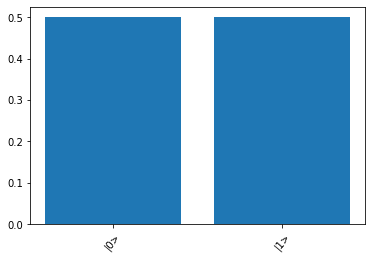

[0.5, 0.5]


In [7]:
res_a = logicQuBit.Measure_One(a)
print(res_a)
res = logicQuBit.Measure([b]) # x = medir(b)
logicQuBit.Plot()
print(res)

In [20]:
def Text2List(table):
    list = [int(i, base=2) for i in table]
    size = len(table[0])
    tmp = sorted(list, key=int, reverse=False)  # values in ascending order
    result = [[int(bin(j)[2:].zfill(size)[i]) for i in range(size)] for j in tmp]
    return result

def BinList(n):
    blist = []
    for i in iter(range(2 ** n)):
        b = bin(i)[2:].zfill(n)  # value in binary, ex: i=1, n=4 -> '0001'
        blist.append(b)
    return Text2List(blist)

#size=3
#blist = [value for i,value in enumerate(BinList(size)) if res[i]>0.1] 
#results = [sum([value/2**(i+1) for i,value in enumerate(j)]) for j in blist]
#print(results)

In [16]:
# todos possíveis valores
size = 2
blist = [[i >> bl & 0x1 for bl in range(size)][::-1] for i in range(2**size)]
results = [2*pi*sum([value/2**(i+1) for i,value in enumerate(j)]) for j in blist]
results

[0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469]

In [74]:
h_eigenvalue = np.linalg.eigh(A)
print(h_eigenvalue)

(array([0.06666667, 0.13333333]), matrix([[-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]))


In [75]:
b  = [1, 1] 
a1 = h_eigenvalue[0][0]
a2 = h_eigenvalue[0][1]
v1 = h_eigenvalue[1][0]
v2 = h_eigenvalue[1][1]

In [76]:
# multiplicar lamb^-1 por a_i*v_i
(a1*v1+a2*v2)*0.75

matrix([[0.03535534, 0.10606602]])

In [77]:
x = sqrt(1/(b[0]**2/a1**2 + b[1]**2/a2**2))*(b[0]/a1*v1 + b[1]/a2*v2)
x

matrix([[-0.31622777+0.j,  0.9486833 +0.j]])

In [96]:
vd = np.matrix([0.375, -0.125])
v = vd.transpose().conjugate() 

In [7]:
# Experimental quantum computing to solve systems of linear equations
logicQuBit  = LogicQuBit(4)

a = Qubit()
c1 = Qubit()
c2 = Qubit()
b = Qubit()

b.H()
c2.CNOT(b)
c1.CNOT(c2)
c2.X()
b.H()

swap(c1,c2)
swap(c1,c2)

a.CRY(c1, pi/8)
a.CRY(c2, pi/16)

c1.H()
c2.H()

logicQuBit.getDictPsi()

{'0000': (0.4939925017688567+0j),
 '0001': (0.00359986156724162+0j),
 '0010': (-0.00359986156724162+0j),
 '0011': (-0.4939925017688567+0j),
 '0100': (0.00359986156724162+0j),
 '0101': (0.4939925017688567+0j),
 '0110': (-0.4939925017688567+0j),
 '0111': (-0.00359986156724162+0j),
 '1000': (0.07327686558642219+0j),
 '1001': (-0.0242682954216419+0j),
 '1010': (0.0242682954216419+0j),
 '1011': (-0.07327686558642219+0j),
 '1100': (-0.0242682954216419+0j),
 '1101': (0.07327686558642219+0j),
 '1110': (-0.07327686558642219+0j),
 '1111': (0.0242682954216419+0j)}